In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/CropDisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [ ]:
# Set up the parameters for the data generators
train_data_dir = '/content/CropDisease/train'
test_data_dir = '/content/CropDisease/test'
batch_size = 32
img_size = (256, 256)

In [ ]:
# Set up the data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

Found 44343 images belonging to 39 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

Found 11105 images belonging to 39 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical


In [ ]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
n_classes = 39

In [ ]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

In [ ]:
# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False

In [ ]:
INIT_LR = 1e-3

In [ ]:
# model.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model

In [ ]:
# plot_model(model)

In [ ]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/5
1385/1385 [==============================] - 778s 550ms/step - loss: 0.0303 - accuracy: 0.8044 - val_loss: 0.0175 - val_accuracy: 0.8832
Epoch 2/5
1385/1385 [==============================] - 761s 549ms/step - loss: 0.0151 - accuracy: 0.8981 - val_loss: 0.0171 - val_accuracy: 0.8849
Epoch 3/5
1385/1385 [==============================] - 771s 556ms/step - loss: 0.0125 - accuracy: 0.9148 - val_loss: 0.0121 - val_accuracy: 0.9156
Epoch 4/5
1385/1385 [==============================] - 759s 547ms/step - loss: 0.0112 - accuracy: 0.9225 - val_loss: 0.0110 - val_accuracy: 0.9211
Epoch 5/5
1385/1385 [==============================] - 750s 542ms/step - loss: 0.0101 - accuracy: 0.9295 - val_loss: 0.0113 - val_accuracy: 0.9184


In [ ]:
model.save('InceptionFirst.h5')

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
# Generate predictions for the test set
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Generate a classification report with output_dict=True
report = classification_report(y_true, y_pred, output_dict=True)

348/348 [==============================] - 42s 112ms/step


In [ ]:
# create a dataframe from the classification report
df = pd.DataFrame(report).transpose()

In [ ]:
df.tail(12)

,precision,recall,f1-score,support
30,0.957746,0.340000,0.501845,200.000000
31,0.761488,0.910995,0.829559,382.000000
32,0.956522,0.575916,0.718954,191.000000
33,0.596296,0.907042,0.719553,355.000000
34,0.834758,0.872024,0.852984,336.000000
35,0.859729,0.676157,0.756972,281.000000
36,0.988473,0.959888,0.973971,1072.000000
37,0.958333,0.613333,0.747967,75.000000
38,0.925926,0.940439,0.933126,319.000000
accuracy,0.918415,0.918415,0.918415,0.918415


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('dark_background')

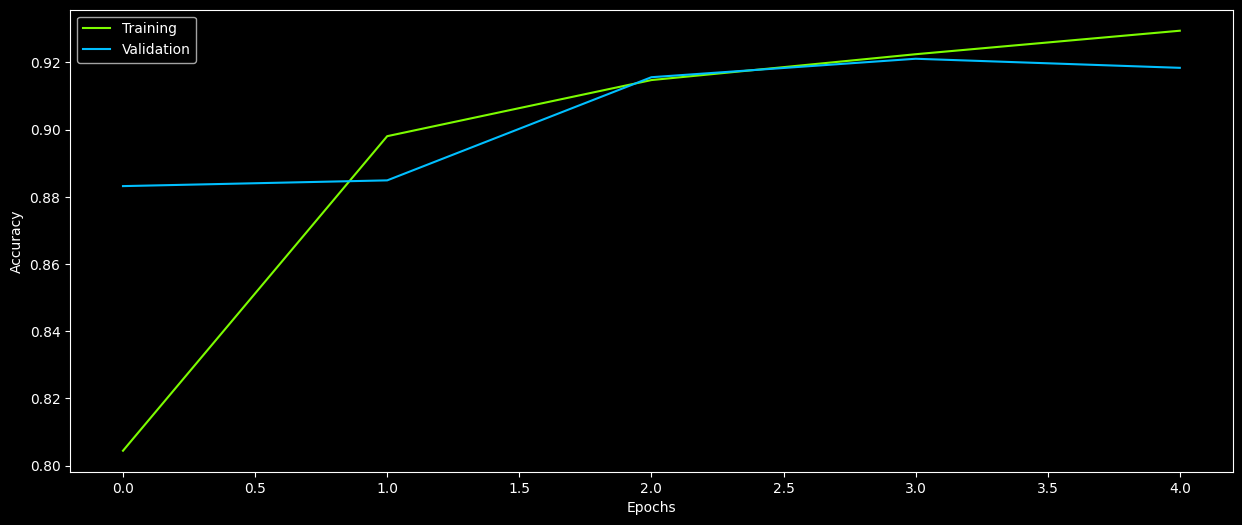

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(15,6))
plt.plot(epochs,acc,c="lawngreen",label="Training")
plt.plot(epochs,val_acc,c="deepskyblue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

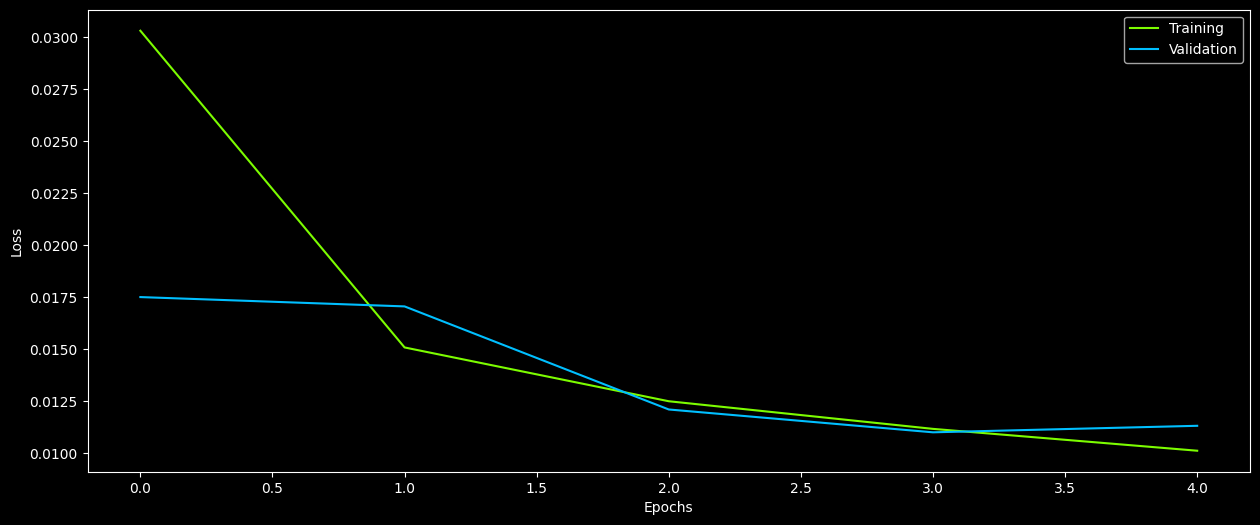

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(15,6))
plt.plot(epochs,loss,c="lawngreen",label="Training")
plt.plot(epochs,val_loss,c="deepskyblue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()